In [1]:
import pandas as pd
df = pd.read_csv('ultimate.csv')

In [12]:
import pandas as pd

def process_csv():
    # 1. Read the CSV
    df = pd.read_csv('ultimate.csv')

    # Ensure required columns exist
    if 'dd_mobile_own_5' not in df.columns or 'dd_mobile_own_4' not in df.columns:
        print("Error: Columns 'dd_mobile_gap_5' or 'dd_mobile_gap_4' not found in the CSV.")
        return

    # 2. Calculate the difference
    difference = df['dd_mobile_own_5'] - df['dd_mobile_own_4']

    # 3. Create treatment_status column
    df['treatment_status'] = difference.apply(lambda x: 'treated' if x >= -8 else 'non treated')

    # 4. Save the new column back to ultimate.csv
    df.to_csv('ultimate.csv', index=False)
    print(f"Successfully updated 'ultimate.csv'.")

    # 5. Give a count of treated and non-treated districts
    print("\n--- Treatment Status Counts ---")
    counts = df['treatment_status'].value_counts()
    print(counts)

if __name__ == "__main__":
    process_csv()

Successfully updated 'ultimate.csv'.

--- Treatment Status Counts ---
treatment_status
non treated    470
treated        230
Name: count, dtype: int64


In [13]:
import pandas as pd
import numpy as np
from scipy import stats

def generate_balance_table():
    # 1. Load the data
    try:
        df = pd.read_csv('ultimate.csv')
    except FileNotFoundError:
        print("Error: ultimate.csv not found.")
        return

    # Ensure treatment_status exists
    if 'treatment_status' not in df.columns:
        print("Error: 'treatment_status' column missing. Run the previous script first.")
        return

    # 2. Define the Variable Mapping
    # Format: {'Description for Output': 'Column Name in CSV'}
    
    # Panel A: Individual and Household Characteristics
    panel_a_vars = {
        'Age (Female)': 'f_mean_age',
        'Formal Education (Female)': 'f_mean_education', # Using f_mean_education
        'Literate (Female %)': 'f_pct_literate',
        'Married (Female %)': 'f_pct_married',
        'Household Size': 'f_mean_hh_size',
        'Urban Household (share)': 'urban_share',
        'Wealth Index': 'f_mean_wealth_idx'
    }

    # Panel B: Employment Composition
    # Note: Sector breakdown columns were not in the provided list. 
    # Adding available proxy columns. Add specific columns here if they exist.
    panel_b_vars = {
        'Female LFPR': 'lfpr_percent',
        'Male Currently Working (%)': 'm_pct_currently_working',
        # Placeholders for missing columns - Uncomment and update if you have them:
        # 'Share Agriculture': 'share_agriculture', 
        # 'Share Manufacturing': 'share_manufacturing',
        # 'Share Services': 'share_services',
        # 'Self Employed': 'self_employed_share',
        # 'Wage Employed': 'wage_employed_share'
    }

    # Panel C: Domestic Violence
    panel_c_vars = {
        'Justify Beating (Goes Out)': 'm_justify_beating_goes_out',
        'Justify Beating (Neglects Kids)': 'm_justify_beating_neglect_kids',
        'Experienced Emotional Violence': 'm_experienced_emotional_viol',
        'Experienced Physical Violence (Any)': 'm_experienced_any_physical_viol',
        'Experienced Sexual Violence (Any)': 'm_experienced_any_sexual_viol',
        'Experienced Severe Injury': 'm_experienced_any_listed_injury',
        'Husband Drinks Alcohol': 'm_hp_drinks_alcohol'
    }

    # 3. Helper function to calculate stats
    def calculate_panel(var_dict, panel_name):
        results = []
        
        # Split data
        treated = df[df['treatment_status'] == 'treated']
        control = df[df['treatment_status'] == 'non treated']
        
        N_t = len(treated)
        N_c = len(control)

        for label, col in var_dict.items():
            if col not in df.columns:
                results.append({
                    'Variable': label,
                    'Treated (Mean)': 'N/A',
                    'Non-Treated (Mean)': 'N/A',
                    'T-stat': 'N/A',
                    'Nt': N_t,
                    'Nc': N_c
                })
                continue

            # Get data, drop NaNs for calculation
            t_data = treated[col].dropna()
            c_data = control[col].dropna()

            # Means
            mean_t = t_data.mean()
            mean_c = c_data.mean()

            # T-statistic
            # Equal var=False (Welch's t-test) is safer for different sample sizes/variances
            if len(t_data) > 1 and len(c_data) > 1:
                t_stat, _ = stats.ttest_ind(t_data, c_data, nan_policy='omit', equal_var=False)
            else:
                t_stat = np.nan

            results.append({
                'Variable': label,
                'Treated (Mean)': round(mean_t, 3),
                'Non-Treated (Mean)': round(mean_c, 3),
                'T-stat': round(t_stat, 3),
                'Nt': len(t_data), # Actual N used in calc
                'Nc': len(c_data)  # Actual N used in calc
            })
        
        return pd.DataFrame(results)

    # 4. Generate Panels
    df_a = calculate_panel(panel_a_vars, "Panel A")
    df_b = calculate_panel(panel_b_vars, "Panel B")
    df_c = calculate_panel(panel_c_vars, "Panel C")

    # 5. Display and Save
    print("\n" + "="*50)
    print("PANEL A: Individual and Household Characteristics")
    print("="*50)
    print(df_a.to_string(index=False))

    print("\n" + "="*50)
    print("PANEL B: Employment Composition")
    print("="*50)
    print(df_b.to_string(index=False))

    print("\n" + "="*50)
    print("PANEL C: Domestic Violence Indicators")
    print("="*50)
    print(df_c.to_string(index=False))

    # Optional: Save to CSV
    with open('balance_table_results.txt', 'w') as f:
        f.write("PANEL A\n")
        f.write(df_a.to_string(index=False))
        f.write("\n\nPANEL B\n")
        f.write(df_b.to_string(index=False))
        f.write("\n\nPANEL C\n")
        f.write(df_c.to_string(index=False))
    
    print("\nResults saved to 'balance_table_results.txt'")

if __name__ == "__main__":
    generate_balance_table()


PANEL A: Individual and Household Characteristics
                 Variable  Treated (Mean)  Non-Treated (Mean)  T-stat  Nt  Nc
             Age (Female)          30.550              30.528   0.209 230 470
Formal Education (Female)           1.622               1.570   2.061 230 470
      Literate (Female %)          79.170              77.192   2.069 230 470
       Married (Female %)          71.249              70.712   1.266 230 470
           Household Size           5.405               5.275   2.239 230 470
  Urban Household (share)          27.777              27.117   0.395 230 470
             Wealth Index           3.022               2.909   1.701 230 470

PANEL B: Employment Composition
                  Variable  Treated (Mean)  Non-Treated (Mean)  T-stat  Nt  Nc
               Female LFPR          21.578              21.442   0.117 209 365
Male Currently Working (%)          74.480              74.661  -0.263 230 470

PANEL C: Domestic Violence Indicators
                

In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

def run_regression_analysis():
    # 1. Load Data
    try:
        df = pd.read_csv('ultimate.csv')
    except FileNotFoundError:
        print("Error: ultimate.csv not found.")
        return

    # 2. Prepare Variables
    # Create the change variable if it doesn't exist explicitly
    # Assuming Gap 5 - Gap 4 based on previous context
    if 'change_in_digital_gap' not in df.columns:
        df['change_in_digital_gap'] = df['dd_mobile_own_5'] - df['dd_mobile_own_4']

    # Define variables for the model
    target = 'lfpr_percent' # Mapping for flpr_2019_20
    
    key_regressors = ['change_in_digital_gap', 'dd_mobile_own_5']
    
    # Mapping controls to your provided column list
    controls = [
        'f_mean_education', # Education
        'f_mean_hh_size',   # HH Size
        'f_mean_age',       # Age
        'f_pct_married',    # Marital Status
        'urban_share',      # Urban/Rural
        'f_pct_sc',         # Caste: SC
        'f_pct_st',         # Caste: ST
        'f_pct_obc'         # Caste: OBC
    ]
    
    # Check if 'state' exists for region control
    if 'state' in df.columns:
        region_control = 'state'
    else:
        print("Warning: 'state' column not found. Running without region fixed effects.")
        region_control = None

    # 3. Data Cleaning
    # Select only necessary columns to drop NaNs efficiently
    cols_to_use = [target] + key_regressors + controls
    if region_control:
        cols_to_use.append(region_control)
        
    # Check for missing columns
    missing_cols = [c for c in cols_to_use if c not in df.columns]
    if missing_cols:
        print(f"Error: The following columns are missing in CSV: {missing_cols}")
        return

    data = df[cols_to_use].dropna()
    print(f"Observations used in regression: {len(data)}")

    # 4. Regression Model (OLS)
    # Create dummies for state (Region FE)
    if region_control:
        # drop_first=True to avoid dummy variable trap
        X = pd.get_dummies(data[key_regressors + controls + [region_control]], 
                           columns=[region_control], 
                           drop_first=True, 
                           dtype=float)
    else:
        X = data[key_regressors + controls]

    # Add constant term
    X = sm.add_constant(X)
    y = data[target]

    model = sm.OLS(y, X).fit()

    # 5. Output Table
    print("\n" + "="*80)
    print("REGRESSION RESULTS: Dependent Variable = FLPR")
    print("="*80)
    print(model.summary())
    
    # Save summary to text file
    with open('regression_summary.txt', 'w') as f:
        f.write(model.summary().as_text())

    # 6. Plotting
    sns.set_style("whitegrid")
    
    # --- Plot 1: Scatter (Change in Gap vs FLPR) ---
    plt.figure(figsize=(10, 6))
    sns.regplot(x='change_in_digital_gap', y=target, data=data, 
                scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title('Scatter Plot: Change in Digital Gap vs FLPR', fontsize=14)
    plt.xlabel('Change in Digital Gap (Gap 5 - Gap 4)', fontsize=12)
    plt.ylabel('FLPR (%)', fontsize=12)
    plt.tight_layout()
    plt.savefig('scatter_plot_flpr.png')
    print("\nScatter plot saved as 'scatter_plot_flpr.png'")
    plt.close()

    # --- Plot 2: Coefficient Plot (Key Regressors) ---
    # Extract coefficients and confidence intervals
    params = model.params
    conf = model.conf_int()
    conf['Coef'] = params
    conf.columns = ['Lower CI', 'Upper CI', 'Coef']
    
    # Filter for key regressors only
    plot_data = conf.loc[key_regressors]
    
    plt.figure(figsize=(8, 5))
    
    # Create error bars
    errors = [plot_data['Coef'] - plot_data['Lower CI'], plot_data['Upper CI'] - plot_data['Coef']]
    
    plt.errorbar(x=plot_data['Coef'], y=plot_data.index, xerr=errors, fmt='o', capsize=5, color='blue')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
    
    plt.title('Regression Coefficients (with 95% CI)', fontsize=14)
    plt.xlabel('Coefficient Estimate', fontsize=12)
    plt.yticks(ticks=range(len(key_regressors)), labels=['Change in Digital Gap', 'Digital Gap (NFHS-5)'])
    plt.grid(True, linestyle=':', alpha=0.6)
    
    plt.tight_layout()
    plt.savefig('coefficient_plot.png')
    print("Coefficient plot saved as 'coefficient_plot.png'")
    plt.close()

if __name__ == "__main__":
    run_regression_analysis()

Observations used in regression: 516

REGRESSION RESULTS: Dependent Variable = FLPR
                            OLS Regression Results                            
Dep. Variable:           lfpr_percent   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     19.77
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           6.12e-72
Time:                        21:19:24   Log-Likelihood:                -1828.9
No. Observations:                 516   AIC:                             3730.
Df Residuals:                     480   BIC:                             3883.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

Observations used: 516
                            OLS Regression Results                            
Dep. Variable:           lfpr_percent   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     19.77
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           6.12e-72
Time:                        21:20:58   Log-Likelihood:                -1828.9
No. Observations:                 516   AIC:                             3730.
Df Residuals:                     480   BIC:                             3883.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
con

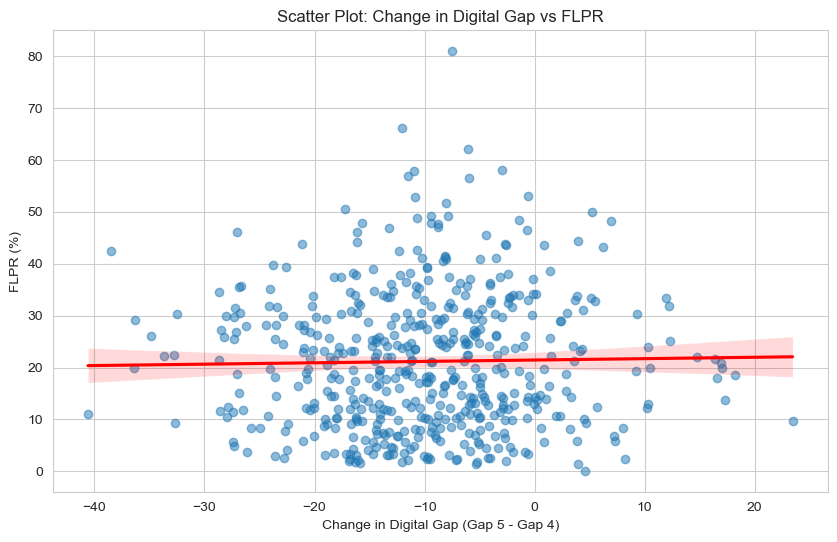

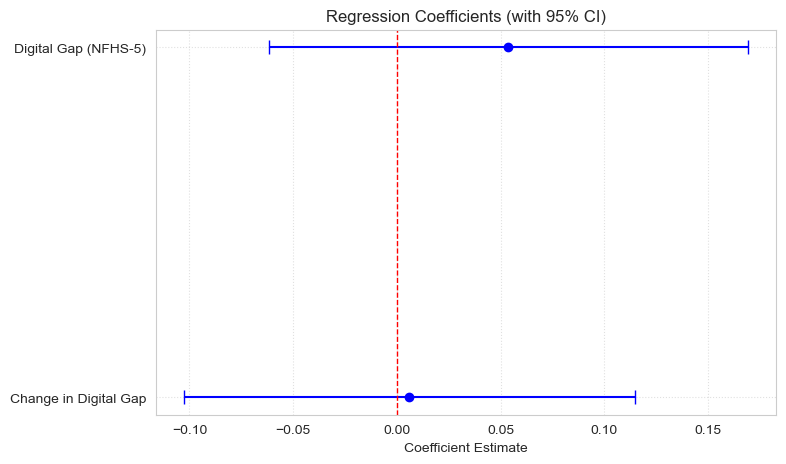

In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
df = pd.read_csv('ultimate.csv')

# 2. Prepare Variables
# Create the change variable
if 'change_in_digital_gap' not in df.columns:
    df['change_in_digital_gap'] = df['dd_mobile_own_5'] - df['dd_mobile_own_4']

# Define variables
target = 'lfpr_percent'
key_regressors = ['change_in_digital_gap', 'dd_mobile_own_5']
controls = [
    'f_mean_education', 
    'f_mean_hh_size',   
    'f_mean_age',       
    'f_pct_married',    
    'urban_share',      
    'f_pct_sc',         
    'f_pct_st',         
    'f_pct_obc'         
]

# Check if 'state' exists for region control
region_control = 'state' if 'state' in df.columns else None

# 3. Data Cleaning
cols_to_use = [target] + key_regressors + controls
if region_control:
    cols_to_use.append(region_control)

# Drop missing values
data = df[cols_to_use].dropna()
print(f"Observations used: {len(data)}")

# 4. Regression Model (OLS)
if region_control:
    X = pd.get_dummies(data[key_regressors + controls + [region_control]], 
                       columns=[region_control], 
                       drop_first=True, 
                       dtype=float)
else:
    X = data[key_regressors + controls]

X = sm.add_constant(X)
y = data[target]

model = sm.OLS(y, X).fit()

# 5. Output Table
print(model.summary())

# 6. Plotting - Scatter Plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

sns.regplot(x='change_in_digital_gap', y=target, data=data, 
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

plt.title('Scatter Plot: Change in Digital Gap vs FLPR')
plt.xlabel('Change in Digital Gap (Gap 5 - Gap 4)')
plt.ylabel('FLPR (%)')

plt.show()

# 7. Plotting - Coefficient Plot
params = model.params
conf = model.conf_int()
conf['Coef'] = params
conf.columns = ['Lower CI', 'Upper CI', 'Coef']

# Filter for key regressors only
plot_data = conf.loc[key_regressors]

plt.figure(figsize=(8, 5))

# Calculate error bar lengths
errors = [plot_data['Coef'] - plot_data['Lower CI'], plot_data['Upper CI'] - plot_data['Coef']]

plt.errorbar(x=plot_data['Coef'], y=plot_data.index, xerr=errors, fmt='o', capsize=5, color='blue')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)

plt.title('Regression Coefficients (with 95% CI)')
plt.xlabel('Coefficient Estimate')
plt.yticks(ticks=range(len(key_regressors)), labels=['Change in Digital Gap', 'Digital Gap (NFHS-5)'])
plt.grid(True, linestyle=':', alpha=0.6)

plt.show()

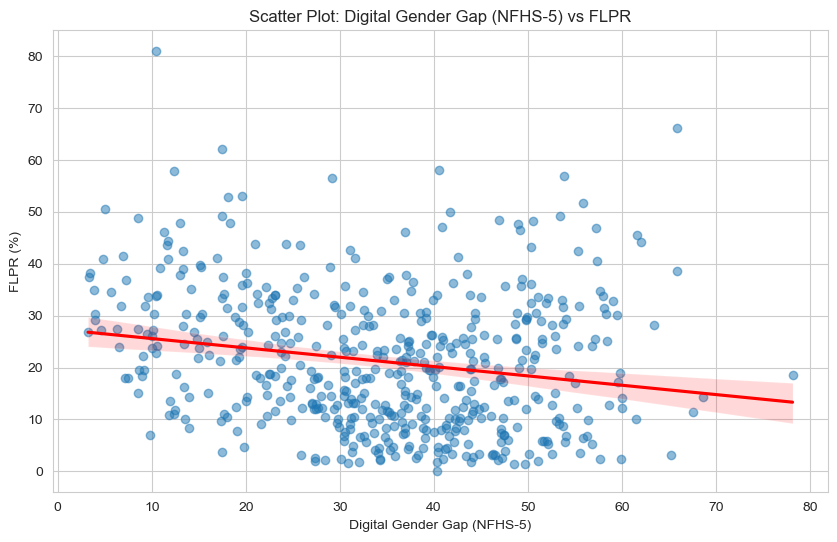

In [19]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# x = dd_mobile_gap_5 (Digital Gender Gap NFHS-5)
# y = lfpr_percent (LFPR)
sns.regplot(x='dd_mobile_own_5', y='lfpr_percent', data=df, 
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

plt.title('Scatter Plot: Digital Gender Gap (NFHS-5) vs FLPR')
plt.xlabel('Digital Gender Gap (NFHS-5)')
plt.ylabel('FLPR (%)')

plt.show()

In [21]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def run_mobile_own_regression():
    # 1. Load Data
    try:
        df = pd.read_csv('ultimate.csv')
    except FileNotFoundError:
        print("Error: ultimate.csv not found.")
        return

    # 2. Define Variables
    target = 'lfpr_percent'
    main_regressor = 'dd_mobile_own_5'

    # Standard controls used in previous analysis
    controls = [
        'f_mean_education', 
        'f_mean_hh_size',   
        'f_mean_age',       
        'f_pct_married',    
        'urban_share',      
        'f_pct_sc',         
        'f_pct_st',         
        'f_pct_obc'         
    ]

    # Check if 'state' exists for region control (Fixed Effects)
    region_control = 'state' if 'state' in df.columns else None

    # 3. Data Cleaning
    cols_to_use = [target, main_regressor] + controls
    if region_control:
        cols_to_use.append(region_control)

    # Check for missing columns
    missing_cols = [c for c in cols_to_use if c not in df.columns]
    if missing_cols:
        print(f"Error: Missing columns: {missing_cols}")
        return

    # Drop missing values
    data = df[cols_to_use].dropna()
    print(f"Observations used: {len(data)}")

    # 4. Regression Model (OLS)
    # Create dummies for state (Region Fixed Effects)
    if region_control:
        X = pd.get_dummies(data[[main_regressor] + controls + [region_control]], 
                           columns=[region_control], 
                           drop_first=True, 
                           dtype=float)
    else:
        X = data[[main_regressor] + controls]

    # Add constant (intercept)
    X = sm.add_constant(X)
    y = data[target]

    # Fit the model
    model = sm.OLS(y, X).fit()

    # 5. Output Table
    print("\n" + "="*80)
    print(f"REGRESSION RESULTS: {target} ~ {main_regressor} + Controls")
    print("="*80)
    print(model.summary())

if __name__ == "__main__":
    run_mobile_own_regression()

Observations used: 516

REGRESSION RESULTS: lfpr_percent ~ dd_mobile_own_5 + Controls
                            OLS Regression Results                            
Dep. Variable:           lfpr_percent   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     20.40
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           1.35e-72
Time:                        21:25:27   Log-Likelihood:                -1828.9
No. Observations:                 516   AIC:                             3728.
Df Residuals:                     481   BIC:                             3876.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


############################################################
PART 2: CHILD NUTRITION (BREASTFEEDING)
############################################################

Running Regression for: Breastfeeding %
                               OLS Regression Results                              
Dep. Variable:     f_pct_ever_breastfed_c1   R-squared:                       0.783
Model:                                 OLS   Adj. R-squared:                  0.766
Method:                      Least Squares   F-statistic:                     45.18
Date:                     Sun, 23 Nov 2025   Prob (F-statistic):          5.53e-147
Time:                             21:27:44   Log-Likelihood:                -1752.2
No. Observations:                      569   AIC:                             3590.
Df Residuals:                          526   BIC:                             3777.
Df Model:                               42                                         
Covariance Type:                 nonrobu

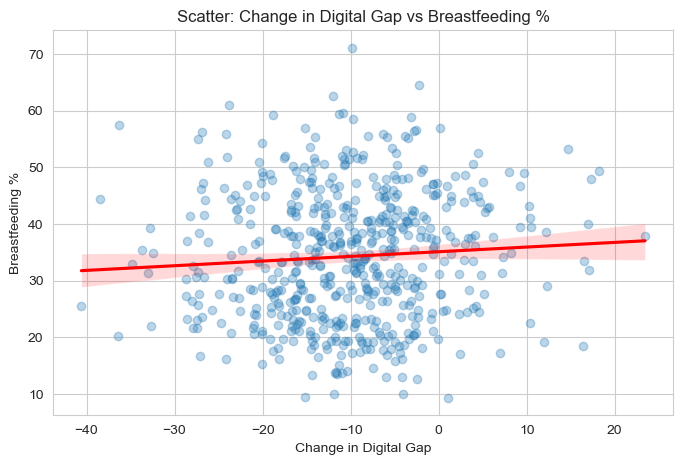


Running Regression for: Breastfeeding Duration
                            OLS Regression Results                            
Dep. Variable:       f_mean_bf_dur_c1   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     42.22
Date:                Sun, 23 Nov 2025   Prob (F-statistic):          4.20e-141
Time:                        21:27:45   Log-Likelihood:                -1657.5
No. Observations:                 569   AIC:                             3401.
Df Residuals:                     526   BIC:                             3588.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

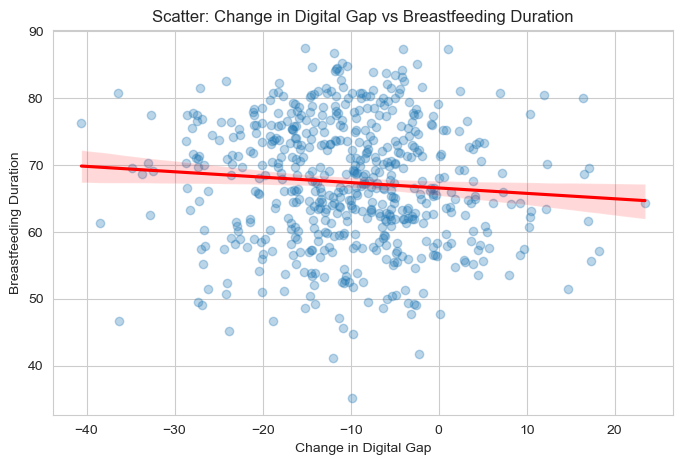

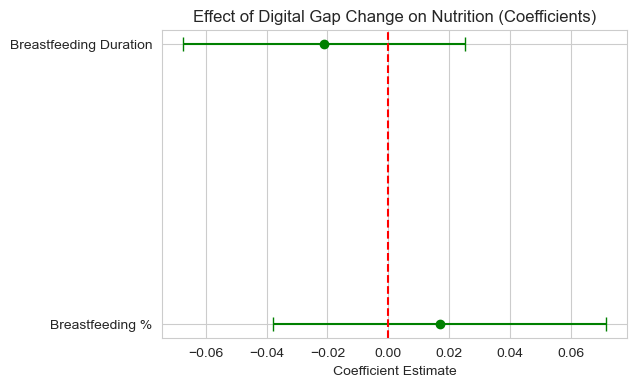

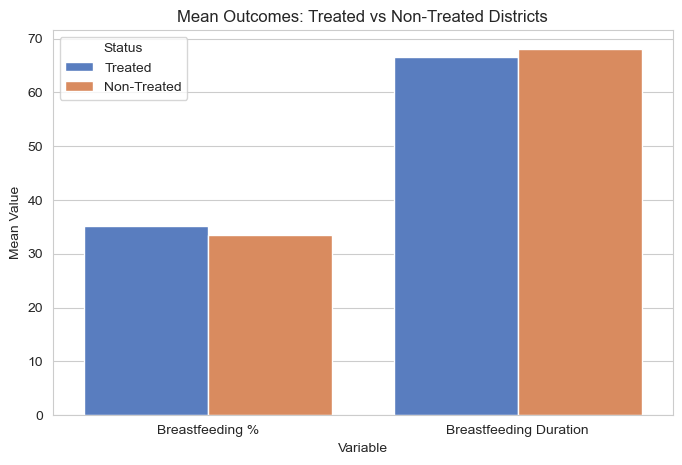


############################################################
PART 3: DOMESTIC VIOLENCE
############################################################

Running Regression for: Ever Slapped
                            OLS Regression Results                            
Dep. Variable:              m_slapped   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     15.35
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           6.30e-67
Time:                        21:27:46   Log-Likelihood:                 224.00
No. Observations:                 569   AIC:                            -362.0
Df Residuals:                     526   BIC:                            -175.2
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                       

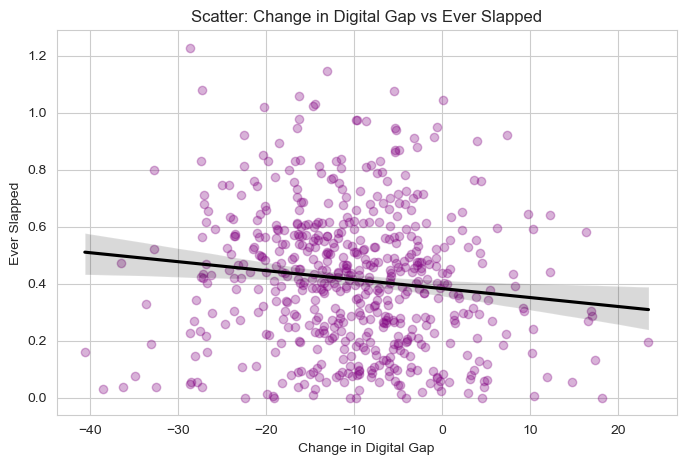


Running Regression for: Ever Hit
                              OLS Regression Results                             
Dep. Variable:     m_punched_hit_harmful   R-squared:                       0.408
Model:                               OLS   Adj. R-squared:                  0.361
Method:                    Least Squares   F-statistic:                     8.641
Date:                   Sun, 23 Nov 2025   Prob (F-statistic):           4.86e-38
Time:                           21:27:47   Log-Likelihood:                 685.45
No. Observations:                    569   AIC:                            -1285.
Df Residuals:                        526   BIC:                            -1098.
Df Model:                             42                                         
Covariance Type:               nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

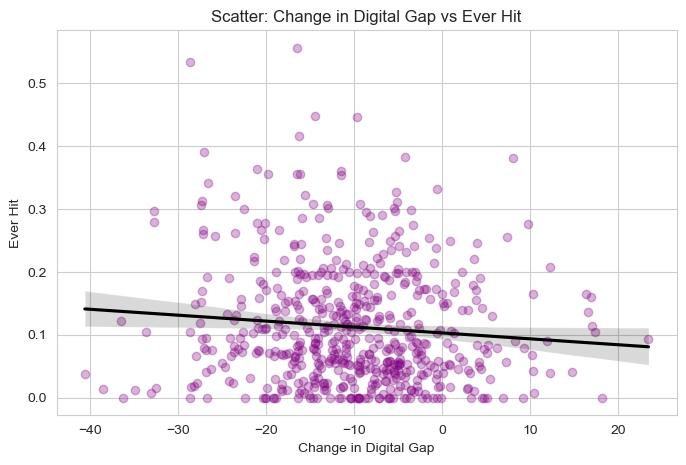


Running Regression for: Sexual Violence
                                  OLS Regression Results                                 
Dep. Variable:     m_experienced_any_sexual_viol   R-squared:                       0.285
Model:                                       OLS   Adj. R-squared:                  0.228
Method:                            Least Squares   F-statistic:                     4.983
Date:                           Sun, 23 Nov 2025   Prob (F-statistic):           1.86e-19
Time:                                   21:27:47   Log-Likelihood:                -1261.9
No. Observations:                            569   AIC:                             2610.
Df Residuals:                                526   BIC:                             2797.
Df Model:                                     42                                         
Covariance Type:                       nonrobust                                         
                                                 coef    st

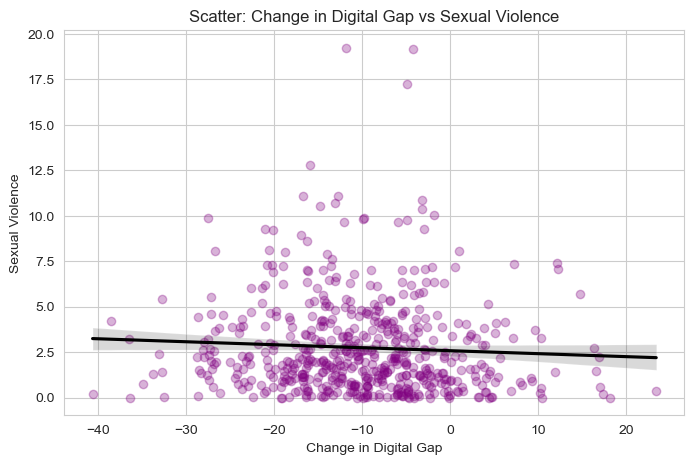

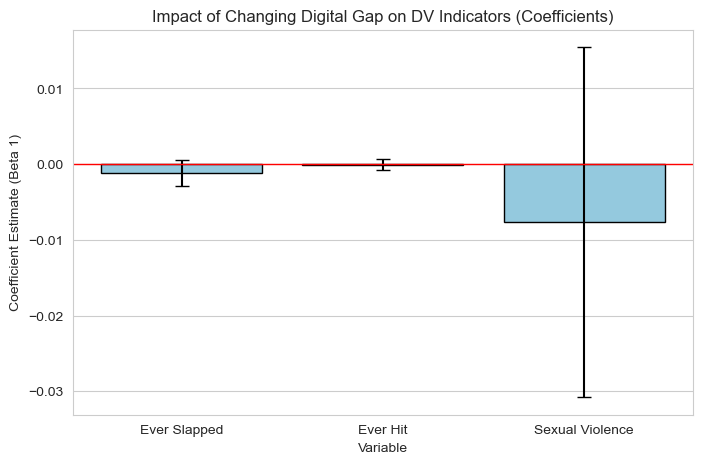

In [23]:
def run_additional_analyses():
    # 1. Load Data
    try:
        df = pd.read_csv('ultimate.csv')
    except FileNotFoundError:
        print("Error: ultimate.csv not found.")
        return

    # 2. Variable Prep
    # Create Regressor: Change in Digital Gap
    if 'change_in_digital_gap' not in df.columns:
        if 'dd_mobile_own_5' in df.columns and 'dd_mobile_own_4' in df.columns:
            df['change_in_digital_gap'] = df['dd_mobile_own_5'] - df['dd_mobile_own_4']
        else:
            print("Error: Cannot calculate change_in_digital_gap. Columns missing.")
            return

    # Create Treatment Status (for mean diff bars) if not exists
    if 'treatment_status' not in df.columns:
        df['treatment_status'] = df['change_in_digital_gap'].apply(lambda x: 'Treated' if x >= -8 else 'Non-Treated')

    # Controls
    controls = [
        'f_mean_education', 'f_mean_hh_size', 'f_mean_age', 'f_pct_married',
        'urban_share', 'f_pct_sc', 'f_pct_st', 'f_pct_obc'
    ]
    
    region_control = 'state' if 'state' in df.columns else None

    # Common function to run regression and get result
    def run_ols(data, target_col, regressor, ctrl_vars, region_fe):
        cols = [target_col, regressor] + ctrl_vars
        if region_fe: cols.append(region_fe)
        
        subset = data[cols].dropna()
        
        if region_fe:
            X = pd.get_dummies(subset[[regressor] + ctrl_vars + [region_fe]], 
                               columns=[region_fe], drop_first=True, dtype=float)
        else:
            X = subset[[regressor] + ctrl_vars]
            
        X = sm.add_constant(X)
        y = subset[target_col]
        
        model = sm.OLS(y, X).fit()
        return model, subset

    sns.set_style("whitegrid")

    # ==========================================
    # PART 2: CHILD NUTRITION (Breastfeeding)
    # ==========================================
    print("\n" + "#"*60)
    print("PART 2: CHILD NUTRITION (BREASTFEEDING)")
    print("#"*60)

    # Variable Mapping
    # Dependent 1: breastfeeding_percentage_nfhs5 -> f_pct_ever_breastfed_c1
    # Dependent 2: breastfeeding_duration_nfhs5 -> f_mean_bf_dur_c1
    nutri_vars = {
        'Breastfeeding %': 'f_pct_ever_breastfed_c1',
        'Breastfeeding Duration': 'f_mean_bf_dur_c1'
    }

    nutri_coeffs = []
    nutri_cis = []

    for label, var in nutri_vars.items():
        if var not in df.columns:
            print(f"Skipping {label}: Column {var} not found.")
            continue

        print(f"\nRunning Regression for: {label}")
        model, valid_data = run_ols(df, var, 'change_in_digital_gap', controls, region_control)
        print(model.summary())

        # Store for Coefficient Plot
        coef = model.params['change_in_digital_gap']
        conf = model.conf_int().loc['change_in_digital_gap']
        nutri_coeffs.append({'Variable': label, 'Coef': coef, 'Lower': conf[0], 'Upper': conf[1]})

        # PLOT 1: Scatter
        plt.figure(figsize=(8, 5))
        sns.regplot(x='change_in_digital_gap', y=var, data=valid_data, 
                    scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
        plt.title(f'Scatter: Change in Digital Gap vs {label}')
        plt.xlabel('Change in Digital Gap')
        plt.ylabel(label)
        plt.show()

    # PLOT 2: Coefficient Plot (Nutrition)
    if nutri_coeffs:
        c_df = pd.DataFrame(nutri_coeffs)
        plt.figure(figsize=(6, 4))
        errors = [c_df['Coef'] - c_df['Lower'], c_df['Upper'] - c_df['Coef']]
        plt.errorbar(x=c_df['Coef'], y=c_df['Variable'], xerr=errors, fmt='o', capsize=5, color='green')
        plt.axvline(x=0, color='red', linestyle='--')
        plt.title('Effect of Digital Gap Change on Nutrition (Coefficients)')
        plt.xlabel('Coefficient Estimate')
        plt.show()

    # PLOT 3: Mean Difference Bars (Treated vs Non-Treated)
    # Re-using the valid data subset logic simply for the bar chart
    mean_diff_data = []
    for label, var in nutri_vars.items():
        if var not in df.columns: continue
        # Calculate means
        grp = df.groupby('treatment_status')[var].mean()
        # Check if keys exist
        t_val = grp.get('treated', grp.get('Treated', 0)) # Handle case sensitivity
        nt_val = grp.get('non treated', grp.get('Non-Treated', 0))
        
        mean_diff_data.append({'Variable': label, 'Status': 'Treated', 'Mean': t_val})
        mean_diff_data.append({'Variable': label, 'Status': 'Non-Treated', 'Mean': nt_val})
    
    if mean_diff_data:
        md_df = pd.DataFrame(mean_diff_data)
        plt.figure(figsize=(8, 5))
        sns.barplot(x='Variable', y='Mean', hue='Status', data=md_df, palette='muted')
        plt.title('Mean Outcomes: Treated vs Non-Treated Districts')
        plt.ylabel('Mean Value')
        plt.show()

    # ==========================================
    # PART 3: DOMESTIC VIOLENCE
    # ==========================================
    print("\n" + "#"*60)
    print("PART 3: DOMESTIC VIOLENCE")
    print("#"*60)

    # Variable Mapping
    dv_vars = {
        'Ever Slapped': 'm_slapped',
        'Ever Hit': 'm_punched_hit_harmful',
        'Sexual Violence': 'm_experienced_any_sexual_viol'
    }

    dv_coeffs = []

    for label, var in dv_vars.items():
        if var not in df.columns:
            print(f"Skipping {label}: Column {var} not found.")
            continue

        print(f"\nRunning Regression for: {label}")
        model, valid_data = run_ols(df, var, 'change_in_digital_gap', controls, region_control)
        print(model.summary())

        # Store for Coefficient Bar Chart
        coef = model.params['change_in_digital_gap']
        conf = model.conf_int().loc['change_in_digital_gap']
        dv_coeffs.append({'Variable': label, 'Coef': coef, 'Lower': conf[0], 'Upper': conf[1]})

        # PLOT 1: Scatter (Three independent scatters requested)
        plt.figure(figsize=(8, 5))
        sns.regplot(x='change_in_digital_gap', y=var, data=valid_data, 
                    scatter_kws={'alpha':0.3, 'color': 'purple'}, line_kws={'color':'black'})
        plt.title(f'Scatter: Change in Digital Gap vs {label}')
        plt.xlabel('Change in Digital Gap')
        plt.ylabel(label)
        plt.show()

    # PLOT 2: Coefficient Bar Chart (Comparing Beta_1 across indicators)
    if dv_coeffs:
        dv_df = pd.DataFrame(dv_coeffs)
        plt.figure(figsize=(8, 5))
        
        # Using a bar chart for coefficients as requested
        sns.barplot(x='Variable', y='Coef', data=dv_df, color='skyblue', edgecolor='black')
        
        # Adding error bars manually on top of the bars
        # This can be tricky with barplot, so we use errorbar overlay
        plt.errorbar(x=range(len(dv_df)), y=dv_df['Coef'], 
                     yerr=[dv_df['Coef'] - dv_df['Lower'], dv_df['Upper'] - dv_df['Coef']], 
                     fmt='none', c='black', capsize=5)
        
        plt.axhline(y=0, color='red', linestyle='-', linewidth=1)
        plt.title('Impact of Changing Digital Gap on DV Indicators (Coefficients)')
        plt.ylabel('Coefficient Estimate (Beta 1)')
        plt.show()

if __name__ == "__main__":
    run_additional_analyses()